In [18]:
import random

import matplotlib.pyplot as plt
import torch
import numpy as np
import skimage
import torchvision.transforms as T

from src.data.augmenters import NoAugmenter, EigenAugmenter, MyAugmenter
from src.data.patch_samplers import NoPatchSampler, EigenPatchSampler, MyPatchSampler
from src.data.kitti_raw import KITTIRAWDataset
from src.data.transforms import warp, scale_through_depth

In [2]:
kitti_path: str = '/media/antonio/523f31c5-dc82-4dce-8457-65b5dd1f19e4/kitti'

In [3]:
plain_dataset = KITTIRAWDataset(
        NoAugmenter(),
        NoPatchSampler(),
        kitti_path,
        'train',
        'png',
)

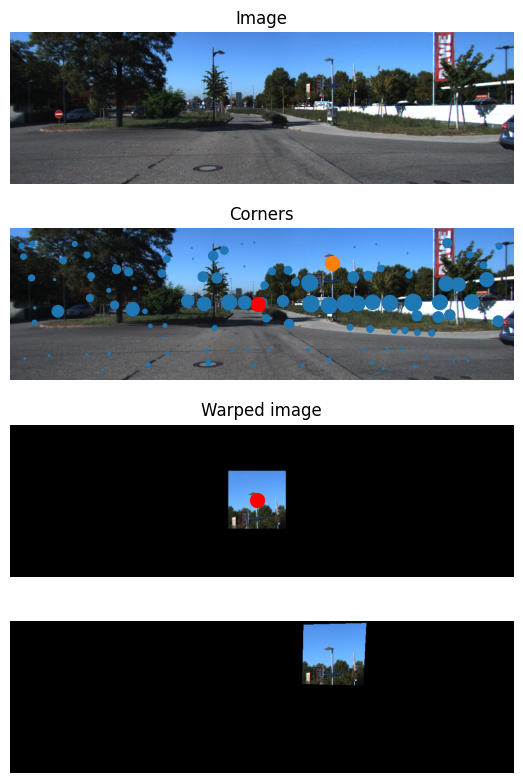

In [84]:
image, depth_map, camera_parameters = plain_dataset[2]
image, camera_parameters = scale_through_depth(image, camera_parameters, 1) 

fig, (img_ax, corners_ax, warp_ax, back_warp_ax) = plt.subplots(4, 1, figsize=(8, 8))
plt.tight_layout()
image = image[0]

np_image = image.permute(1, 2, 0).numpy()
depth_map = depth_map[0, 0].numpy()

yy, xx = np.nonzero(depth_map)

################################################################################
img_ax.set_title("Image")
img_ax.axis("off")
img_ax.imshow(np_image)
#img_ax.scatter(xx, yy, c=depth_map[yy, xx], s=0.1, cmap="gist_rainbow")

################################################################################
np_corner_response = skimage.feature.corner_moravec(skimage.color.rgb2gray(np_image))

# np_corner_response = clean_corner_response(np_corner_response)

# Sample peaks of interest
peaks = skimage.feature.corner_peaks(np_corner_response, min_distance=25) # TODO: this can be empty

corners_ax.set_title("Corners")
corners_ax.axis("off")
corners_ax.imshow(np_image)
corners_ax.scatter(peaks[:, 1], peaks[:, 0], s=100*np_corner_response[peaks[:, 0], peaks[:, 1]])
corners_ax.scatter(camera_parameters['K'][0, 2], camera_parameters['K'][1, 2], c='r', s=100)

################################################################################
y, x = peaks[random.choice(range(peaks.shape[0])), :]

corners_ax.scatter([x], [y], s=100)

w_image, w_camera_params, inv_bil, inv_nn = warp(image, camera_parameters, x, y, T.InterpolationMode.BILINEAR, return_inverse=True)
cx, cy = int(w_camera_params['K'][0, 2]), int(w_camera_params['K'][1, 2])
np_w_image = w_image.permute(1, 2, 0).numpy()
half_h, half_w = 70, 70
np_w_image[:cy-half_h, :, :] = 0
np_w_image[cy+half_h:, :, :] = 0
np_w_image[:, :cx-half_w, :] = 0
np_w_image[:, cx+half_w:, :] = 0

warp_ax.set_title("Warped image")
warp_ax.axis("off")
warp_ax.imshow(np_w_image)
warp_ax.scatter(cx, cy, c='r', s=100)

mask = (np_w_image != 0)

################################################################################

b_mask = inv_nn(torch.from_numpy(mask.astype(np.float32)).permute(2, 0, 1))
back_warp_ax.axis("off")
back_warp_ax.imshow(np_image * b_mask.permute(1, 2, 0).numpy())

plt.show()